In [1]:
import os, time
import numpy as np
import pandas as pd
from keras.models import load_model
from PIL import Image
#import openslide
from math import floor
import glob
#import progressbar
#import staintools
#from staintools import ReinhardColorNormalizer
import sys
import gc
os.environ["CUDA_VISIBLE_DEVICES"]=""

Using TensorFlow backend.
/home/stand/anaconda3/envs/Path/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:523: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/stand/anaconda3/envs/Path/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:524: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/stand/anaconda3/envs/Path/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:525: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/stand/anaconda3/envs/Pa

In [2]:
from vis.visualization import visualize_cam, overlay
from vis.utils import utils
from vis.visualization import visualize_saliency
import matplotlib.pyplot as plt
import numpy as np
from keras import activations
import matplotlib.cm as cm

In [3]:
from keras.models import *
from keras.callbacks import *
import keras.backend as K
import cv2

In [4]:
model = load_model('/media/disk1/Necrosis/model/conductor_model.h5')
model.load_weights('/media/disk1/Necrosis/model/10folder_weights.hdf5')

In [5]:
# Utility to search for layer index by name. 
# Alternatively we can specify this as -1 since it corresponds to the last layer.
layer_idx = utils.find_layer_idx(model, 'predictions')

# Swap softmax with linear
model.layers[layer_idx].activation = activations.linear
model = utils.apply_modifications(model)

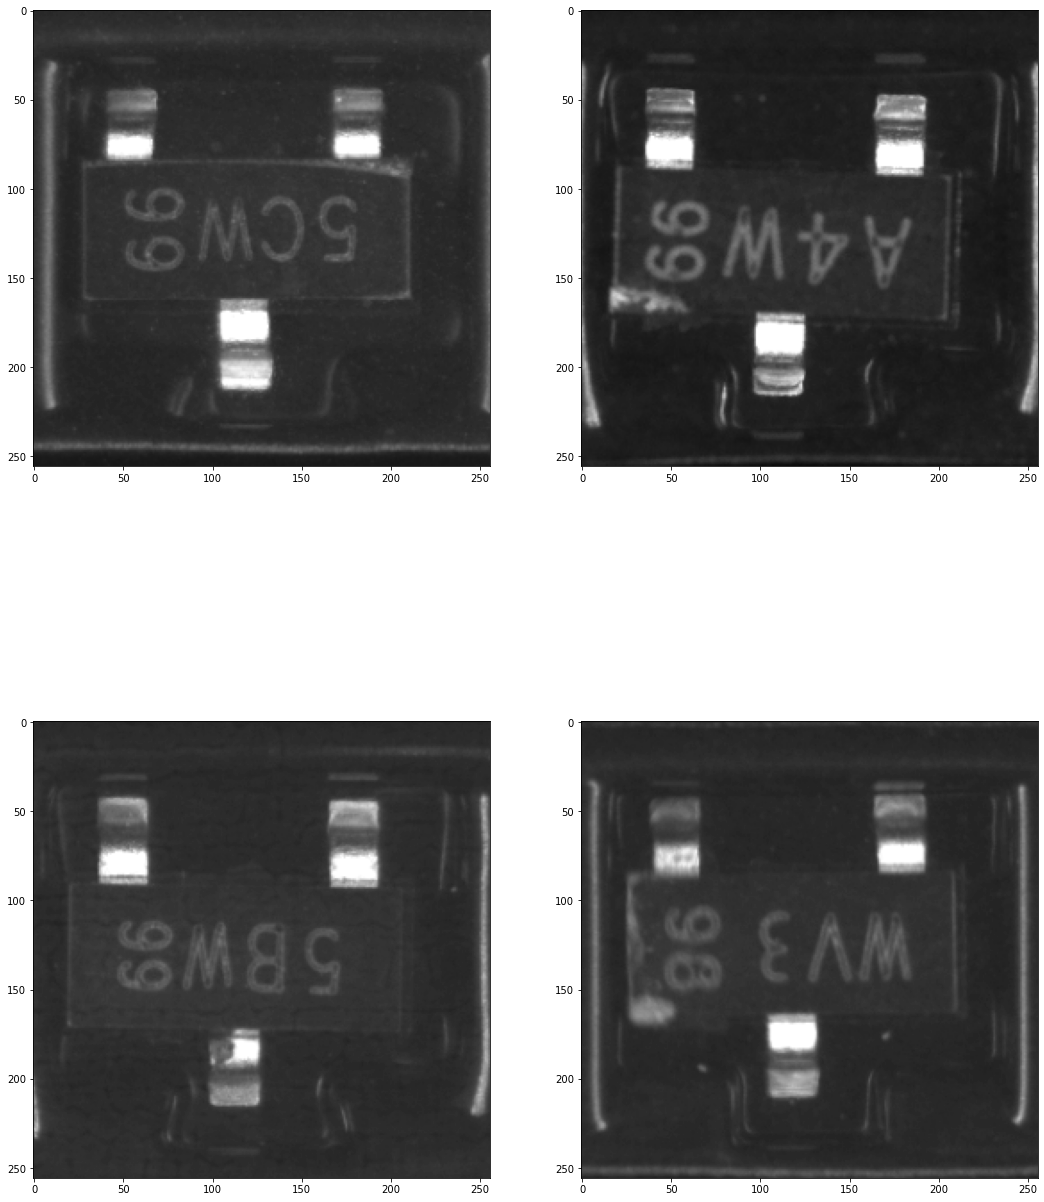

In [6]:
plt.rcParams['figure.figsize'] = (18, 24)

img_path = 'conductor_image/test_contest/defect/'
defect_list = [f for f in os.listdir(img_path) if f.endswith('bmp')]

img1 = utils.load_img(img_path+defect_list[0], target_size=(256, 256))
img2 = utils.load_img(img_path+defect_list[1], target_size=(256, 256))
img3 = utils.load_img(img_path+defect_list[2], target_size=(256, 256))
img4 = utils.load_img(img_path+defect_list[3], target_size=(256, 256))


f, ax = plt.subplots(2, 2)
ax[0][0].imshow(img1,cmap='gray', vmin=0, vmax=255)
ax[0][1].imshow(img2,cmap='gray', vmin=0, vmax=255)
ax[1][0].imshow(img3,cmap='gray', vmin=0, vmax=255)
ax[1][1].imshow(img4,cmap='gray', vmin=0, vmax=255)

In [7]:
import numpy as np
import matplotlib.cm as cm
from tqdm import tqdm
from vis.visualization import visualize_cam
penultimate_layer = utils.find_layer_idx(model, 'conv_7b')

#for modifier in [None, 'guided', 'relu']:
#f, ax = plt.subplots(4, 1)
img_list = defect_list
modifier = 'relu'
for i, img_file in enumerate(tqdm(img_list)):   
    img = Image.open(img_path+img_file)
    img = img.convert('RGB')
    resize_img = img.resize((256,256),Image.ANTIALIAS)
    resize_arr = np.asarray(resize_img,dtype="float32")
    temp = np.empty((1,256,256,3),dtype="float32")
    temp[0,:,:,:] = resize_arr
    Pred_data = temp.astype('float32')
    Pred_data /= 255.0
    # 20 is the imagenet index corresponding to `ouzel`
    grads = visualize_cam(model, layer_idx, filter_indices=0, 
                            seed_input=Pred_data, penultimate_layer_idx=penultimate_layer,
                            backprop_modifier=modifier)        
    # Lets overlay the heatmap onto original image.    
    jet_heatmap = np.uint8(cm.jet(grads)[..., :3] * 255*0.8)
    #plt.imshow(overlay(jet_heatmap, resize_arr))
    #plt.xticks([])
    #plt.yticks([])
    plt.imsave('conductor_attention_classweights/'+img_file.split('.')[0]+'.png',overlay(jet_heatmap, resize_arr))

100%|██████████| 1408/1408 [14:45:25<00:00, 37.73s/it]  


In [8]:
from numba import cuda
cuda.select_device(0)
cuda.close()